Сначала я работал в этом ноутбуке, немного перебирал парметры xgboost, он давал ошибку около 30 в leaderboard. Я не разобрался, почему у меня не работал grid_search и cross_val_score, поэтому делал что-то своё. 
После этого я стал подгонять параметры у RandomForestRegressor, уже небольшая подгонка дала качество 24.8 без какого-либо преобразования датасета.
Далее мне было удобнее перейти в ноутбук "Daniil Korbut contest 2", где я пробовал преобразовывать датасет (продолжение описания содержится там).

In [63]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [34]:
train = shuffle(train)

In [35]:
train = train.sort(['item_id', 'year', 'week', 'shift'])
print (train.shape)
train.head()

(72457, 66)


/Users/daniilkorbut/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
150,150,340138,2012,52,1,20427028,9700.0,92038.0,111363.0,146522.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
841,3613,110776,2013,1,1,20427028,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0
380,380,110776,2013,1,2,20427028,9700.0,92038.0,111363.0,146522.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
1536,7079,70915,2013,2,1,20427028,111363.0,146522.0,174408.0,111337.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
1072,3844,70915,2013,2,2,20427028,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0


In [36]:
y = np.array(train["y"])

In [37]:
example = train[train["item_id"] == 20427028]
print (example.shape)
example.head(10)

(321, 66)


,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
150,150,340138,2012,52,1,20427028,9700.0,92038.0,111363.0,146522.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
841,3613,110776,2013,1,1,20427028,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0
380,380,110776,2013,1,2,20427028,9700.0,92038.0,111363.0,146522.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
1536,7079,70915,2013,2,1,20427028,111363.0,146522.0,174408.0,111337.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
1072,3844,70915,2013,2,2,20427028,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0
611,611,70915,2013,2,3,20427028,9700.0,92038.0,111363.0,146522.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
2240,10552,149741,2013,3,1,20427028,146522.0,174408.0,111337.0,124149.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0
1780,7323,149741,2013,3,2,20427028,111363.0,146522.0,174408.0,111337.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
1316,4088,149741,2013,3,3,20427028,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0
2919,13997,203508,2013,4,1,20427028,174408.0,111337.0,124149.0,119286.0,...,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,93007.0


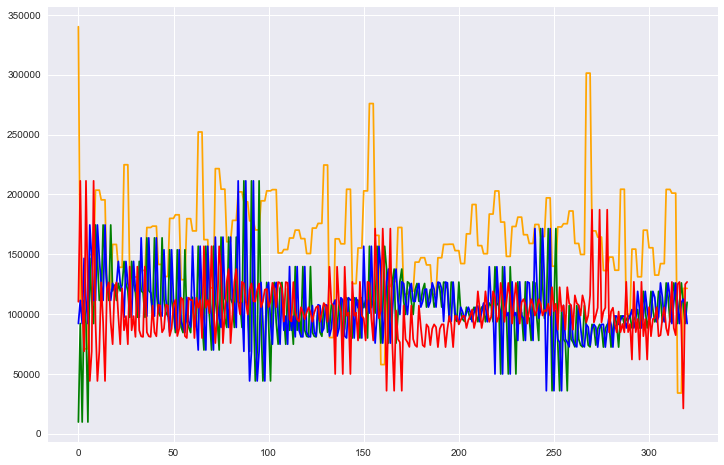

In [66]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(example.shape[0])], example['y'], color = "orange")
plt.plot([i for i in range(example.shape[0])], example['f1'], color = "green")
plt.plot([i for i in range(example.shape[0])], example['f2'], color = "blue")
plt.plot([i for i in range(example.shape[0])], example['f60'], color = "red")
plt.show()

In [39]:
train1 = train.head(50000)
train2 = train.tail(train.shape[0]-50000)

In [48]:
def smape(y_pred, y_true):
    return (100 / y_pred.shape[0]) * np.sum(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

In [41]:
a = np.array([2,2,3])
b = np.array([1,2,3])

In [42]:
smape(_,a,b)

22.222222222222221

In [43]:
X1 = train1.drop(['Num','y'], axis=1)
y1 = train1['y']
X2 = train2.drop(['Num','y'], axis=1)
y2 = train2['y']
y1 = np.array(y1)
y2 = np.array(y2)

In [44]:
model = RandomForestRegressor(n_estimators=30, min_samples_leaf=1, min_samples_split=2)

In [53]:
results = []
for n_e in [10, 20, 30, 40]:
    for m_s_l in [1, 2, 3, 4, 5]:
        for m_s_s in [2, 3, 4]:
            tmp = []
            for i in range(5):
                train = shuffle(train)
                train1 = train.head(50000)
                train2 = train.tail(train.shape[0]-50000)
                X1 = train1.drop(['Num','y'], axis=1)
                y1 = train1['y']
                X2 = train2.drop(['Num','y'], axis=1)
                y2 = train2['y']
                y1 = np.array(y1)
                y2 = np.array(y2)
                model = RandomForestRegressor(n_estimators=n_e, min_samples_leaf=m_s_l, min_samples_split=m_s_s)
                model.fit(X1, y1)
                res = model.predict(X2)
                tmp.append(smape(res, y2))
            results.append((np.mean(tmp), n_e, m_s_l, m_s_s))

KeyboardInterrupt: 

In [54]:
results

[(24.05787671713157, 10, 1, 2),
 (24.03015521977634, 10, 1, 3),
 (24.074953295561574, 10, 1, 4),
 (24.056031963441349, 10, 2, 2),
 (23.986166506338208, 10, 2, 3),
 (23.950650608971095, 10, 2, 4),
 (24.197675050271783, 10, 3, 2),
 (24.152235494549835, 10, 3, 3),
 (24.209165377072981, 10, 3, 4),
 (24.20283479676656, 10, 4, 2),
 (24.292255105571162, 10, 4, 3),
 (24.261426300966583, 10, 4, 4),
 (24.331822110364833, 10, 5, 2),
 (24.392153915597302, 10, 5, 3),
 (24.419393088383679, 10, 5, 4)]

In [55]:
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=2, min_samples_split=4)

In [60]:
model.fit(X1, y1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [58]:
res = model.predict(X2)

In [61]:
smape(res,y2)

24.109993312042384

In [62]:
X = train.drop(['Num','y'], axis=1)
y = train['y']
print (len(X), len(y))

72457 72457


In [26]:
%%time

preds = model.predict(test.drop(['Num'], axis=1))

print (len(preds))
print (len(sample_submission))

2016
2016
CPU times: user 23.9 ms, sys: 2.22 ms, total: 26.1 ms
Wall time: 24.8 ms


In [27]:
sample_submission['y'] = preds

In [28]:
sample_submission.head(5)

,Num,y
0,348622,1954.800000
1,348623,29373.700000
2,348624,343317.300000
3,348625,33851.533333
4,348626,72.333333


In [29]:
# In GBM you can get some negative predictions:
print (sample_submission[sample_submission['y'] < 0])

Empty DataFrame
Columns: [Num, y]
Index: []


In [30]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [31]:
sample_submission.to_csv("my_submission3.tsv", sep=',', index=False)